<a href="https://colab.research.google.com/github/Gaurang-1402/RV-final-project/blob/main/monocular-depth-estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Creating a Data loader

In [61]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np

In [66]:

class MonocularDepthDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        
        # Print the sorted list of paths to all folders in the data directory
        # print(sorted(glob.glob(os.path.join(data_path, "*"))))
            
        for folder in sorted(glob.glob(os.path.join(data_path, "*"))):
            self.rgb_filenames = sorted(glob.glob(os.path.join(folder, "rgb_*.jpg")))
            self.depth_filenames = sorted(glob.glob(os.path.join(folder, "sync_depth_*.png")))
                
            # print("Number of RGB images: {}".format(len(self.rgb_filenames)))
            # print("Number of Depth images: {}".format(len(self.depth_filenames)))


    def __getitem__(self, index):
        rgb = Image.open(self.rgb_filenames[index])
        depth = Image.open(self.depth_filenames[index])

        if self.transforms:
            rgb = self.transforms(rgb)

            # Convert depth image to float
            depth = np.array(depth).astype(np.float32)
            depth = Image.fromarray(depth)

            depth = self.transforms(depth)

        return rgb, depth

    def __len__(self):
        return len(self.rgb_filenames)

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create an instance of the dataset
# ! right now i am only using the basement dataset
# TODO need to use the other datasets also
depth_dataset = MonocularDepthDataset(data_path="../dataset/sync/", transforms=transform)

# Create a DataLoader object
depth_dataloader = DataLoader(depth_dataset, batch_size=32, shuffle=True)

# Iterate over the DataLoader object to get batches of data for training the model
for rgb, depth in depth_dataloader:
    # TODO train the model
    ...


RGB shape: torch.Size([3, 224, 224])
Depth shape: torch.Size([1, 224, 224])


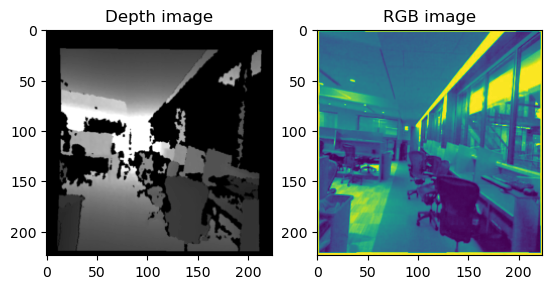

In [67]:
import matplotlib.pyplot as plt

# Get the first batch of data from the DataLoader
rgb, depth = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset)) # get the third batch

# Print the shape of the first batch of depth and RGB images
print("RGB shape:", rgb.shape)

print("Depth shape:", depth.shape)

# Plot the first depth and RGB images in the batch
plt.subplot(1, 2, 1)
plt.imshow(depth[0], cmap='gray')
plt.title("Depth image")
plt.subplot(1, 2, 2)

"""
It looks like the rgb tensor has only two dimensions, 
which is why the permute() operation is failing. 
You can try adding a new dimension to the tensor using the unsqueeze() method before applying the permutation.
"""

plt.imshow(rgb[0].unsqueeze(0).permute(1, 2, 0))
plt.title("RGB image")
plt.show()
